# Double integration

In [110]:
%matplotlib notebook
import importlib
from speed_regression import training_data as td
from speed_regression import imu_optimization as imu_optimization
import numpy as np
import pandas
import sklearn.svm as svm
from sklearn.externals import joblib
from scipy.ndimage.filters import gaussian_filter1d
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import quaternion

import algorithms.double_integration as double_integration
import algorithms.sensor_filter as sensor_filter

from utility.write_trajectory_to_ply import write_ply_to_file

nano_to_sec = 1e09

# configure the size of plot
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

axis_name = 'xyz'
device = 'iphone'

<IPython.core.display.Javascript object>


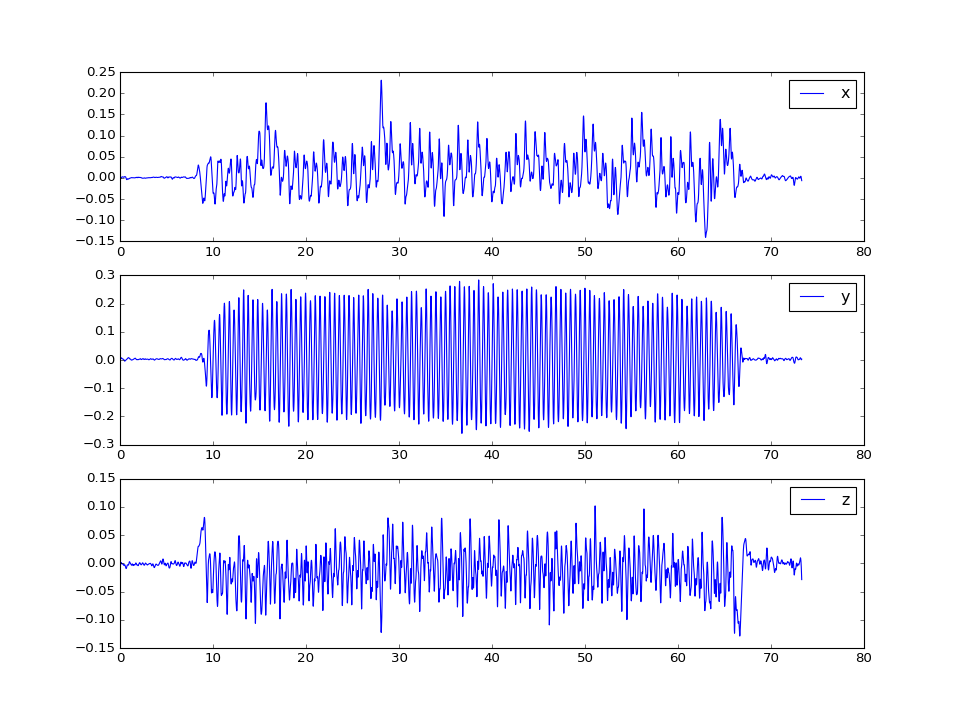

In [60]:
# inspect raw data
data_dir = 'iphone_cse1'
# linacce_raw = np.genfromtxt('../../data/20170221112422/linacce.txt')
linacce_raw = np.genfromtxt('../../data/' + data_dir + '/' + device + '/linacce.txt')
linacce_raw = gaussian_filter1d(linacce_raw, sigma=5.0, axis=0)
time_stamp = linacce_raw[:, 0]
time_stamp = (time_stamp - time_stamp[0]) / nano_to_sec
plt.figure('Raw linear acceleration')
axis_name = 'xyz'
for i in range(3):
    plt.subplot(311+i)
    plt.plot(time_stamp, linacce_raw[:, i+1])
    plt.legend(axis_name[i])

<IPython.core.display.Javascript object>


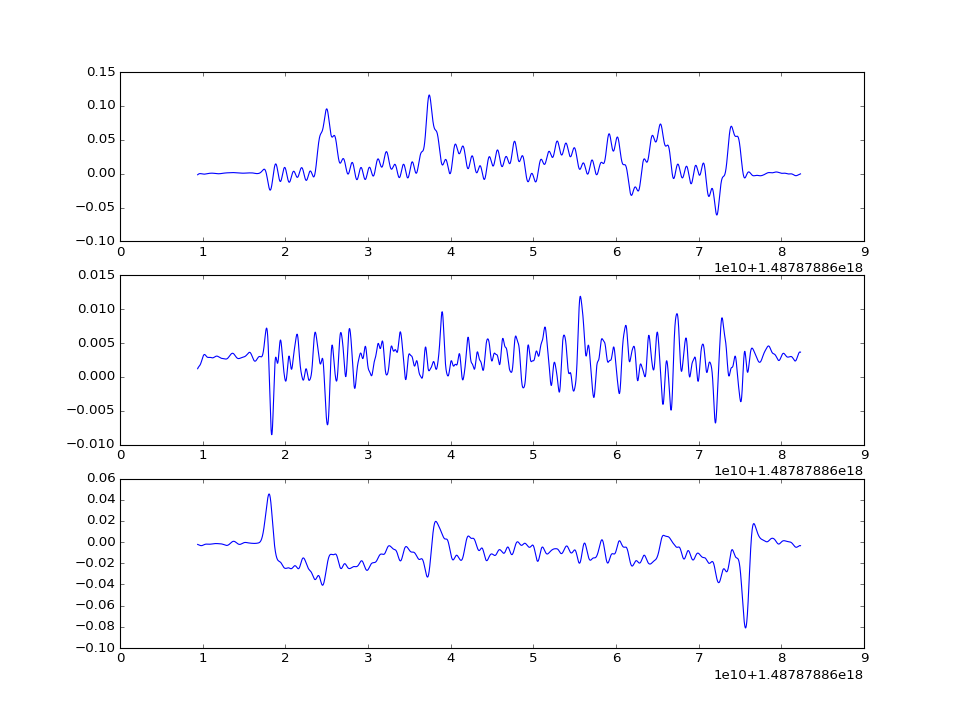

In [63]:
acce_data = np.genfromtxt('../../data/iphone_cse1/iphone/linacce.txt')
filter_sigma = 30.0
acce_data = gaussian_filter1d(acce_data, filter_sigma, axis=0)
plt.figure('Accelerometer')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(acce_data[:, 0], acce_data[:, i+1])

## Test linear acceleration signal

<IPython.core.display.Javascript object>


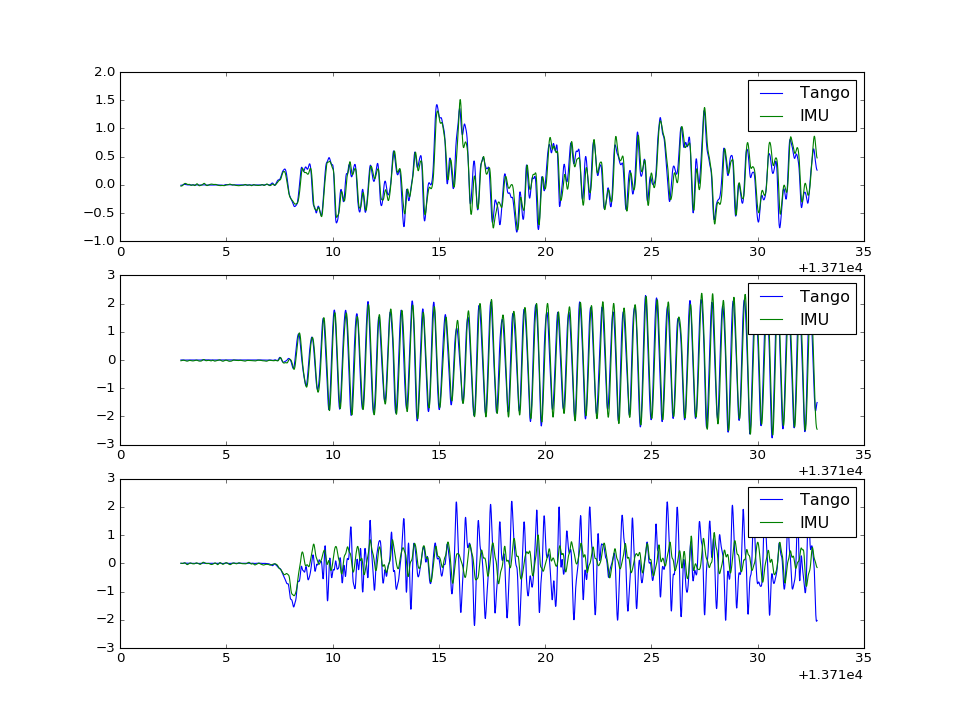

<IPython.core.display.Javascript object>


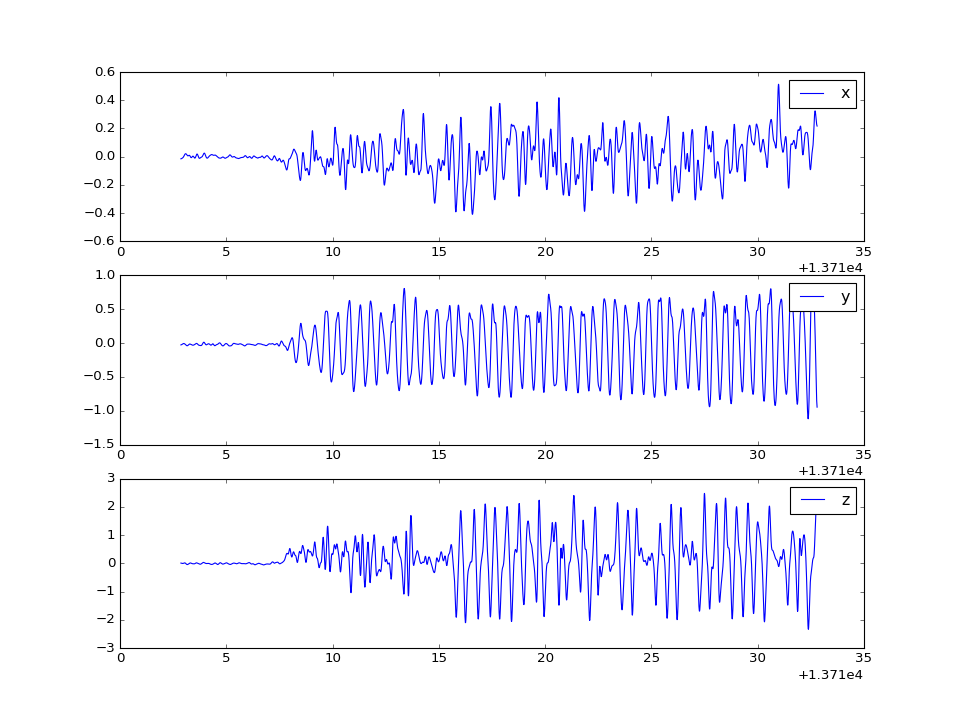

<IPython.core.display.Javascript object>


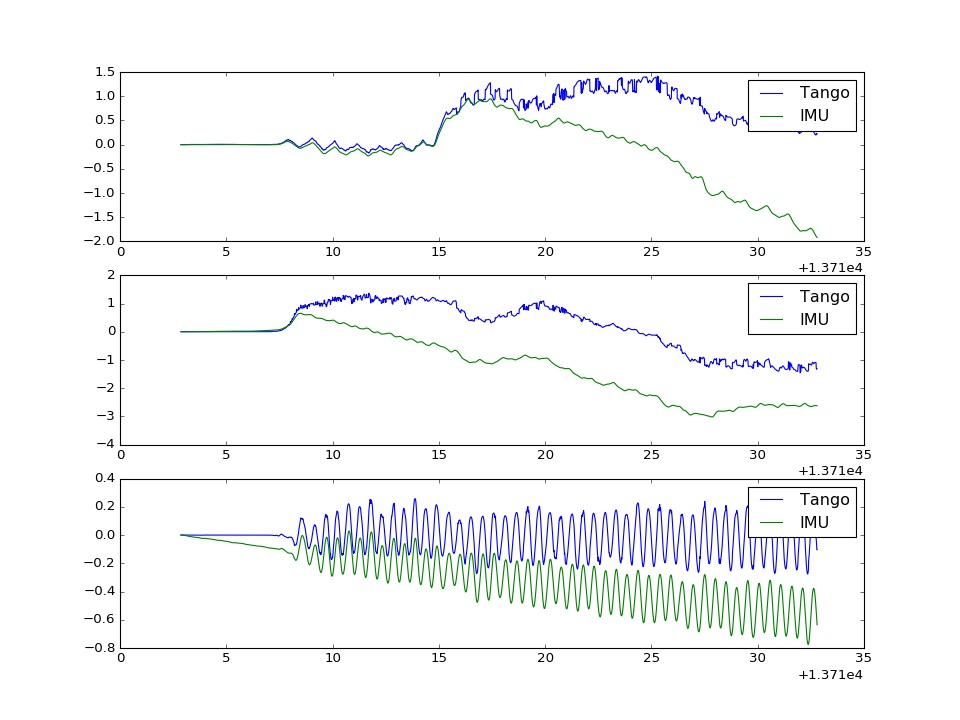

<IPython.core.display.Javascript object>


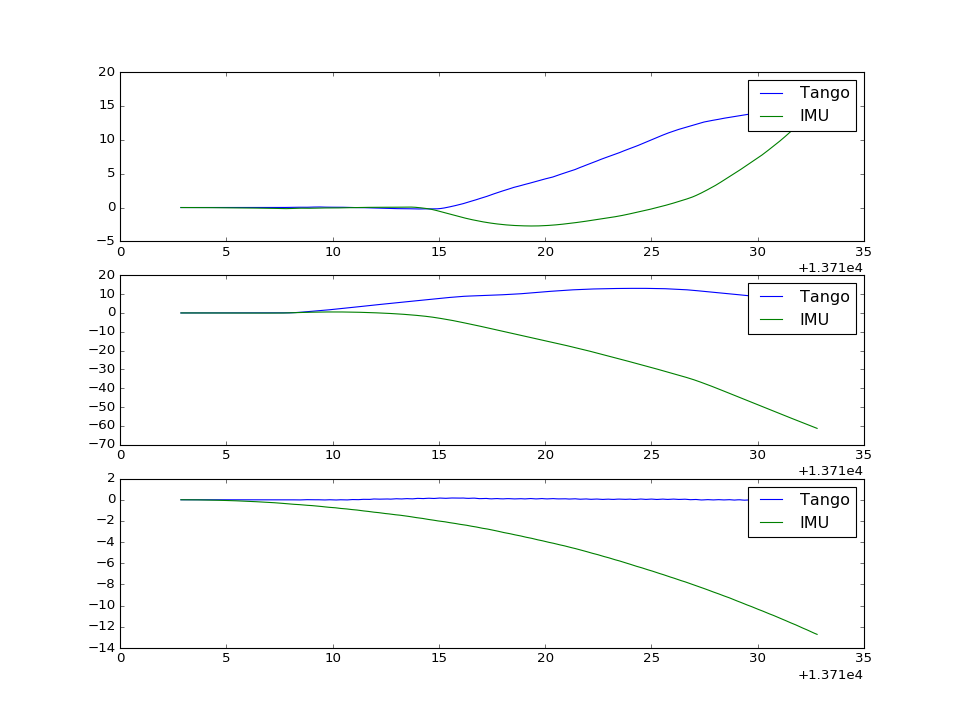

In [135]:
window = 3000

test_data_all = pandas.read_csv('../../data/iphone_data/iphone_cse2/processed/data.csv')
linacce = test_data_all[['linacce_x', 'linacce_y', 'linacce_z']].values[:window]
time_stamp = test_data_all['time'].values[:window] / nano_to_sec

orientation = test_data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values[:window]

# Verify that the linear acceleration and 
# raw_linacce = np.genfromtxt('../../data/iphone_cse1/iphone/linacce_sync.txt')
# raw_time_stamp = raw_linacce[:, 0] / nano_to_sec

# first inspect the interpolation
# plt.figure('Interpolation')
# for i in range(3):
#     plt.subplot(311+i)
#     plt.plot(raw_time_stamp, raw_linacce[:, i+1])
#     plt.plot(time_stamp, linacce[:, i])
#     plt.legend(['Before', 'After'])

time_interval = (time_stamp[1:] - time_stamp[:-1])[:, None]
# compute the linear acceleration from tango pose
pose = test_data_all[['pos_x', 'pos_y', 'pos_z']].values[:window]
speed_tango = (pose[1:, :] - pose[:-1, :]) / time_interval
speed_tango = np.append(speed_tango, [speed_tango[-1]], axis=0)

# filter linear acceleration with a low pass filter
# alpha = 0.1
# linacce = sensor_filter.low_pass_filter(time_stamp, linacce, alpha)

linacce_tango = (speed_tango[1:] - speed_tango[:-1]) / time_interval
linacce_tango = np.append(linacce_tango, [linacce_tango[-1]], axis=0)

undirected_tango_acce = np.empty(linacce_tango.shape, dtype=float)
directed_raw_acce = np.empty(linacce.shape, dtype=float)
for i in range(linacce.shape[0]):
    q = quaternion.quaternion(*orientation[i])
    directed_raw_acce[i] = (q * quaternion.quaternion(1.0, *linacce[i]) * q.conj()).vec
    undirected_tango_acce[i] = (q.conj() * quaternion.quaternion(1.0, *linacce_tango[i]) * q).vec
    
# directed_raw_acce[:, 2] = (directed_raw_acce[:, 2] 
#                            - np.average(directed_raw_acce[:, 2]) + np.average(linacce_tango[:, 2]))

filter_sigma = 5
directed_raw_acce = gaussian_filter1d(directed_raw_acce, sigma=filter_sigma, axis=0)
filtered_raw_acce = gaussian_filter1d(linacce, sigma=filter_sigma, axis=0)
filtered_linacce_tango = gaussian_filter1d(linacce_tango, sigma=filter_sigma, axis=0)
filtered_undirected_tango_acce = gaussian_filter1d(undirected_tango_acce, sigma=filter_sigma, axis=0)

plt.figure('Raw acceleration')
for i in range(directed_raw_acce.shape[1]):
    plt.subplot(100*directed_raw_acce.shape[1] + 11 + i)
    plt.plot(time_stamp, filtered_undirected_tango_acce[:, i])
    plt.plot(time_stamp, filtered_raw_acce[:, i])
    # plt.plot(time_stamp, filtered_linacce_tango[:, i])
    # plt.plot(time_stamp, directed_raw_acce[:, i])
    plt.legend(['Tango', 'IMU'])

# show the bias
plt.figure('Bias')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(time_stamp, filtered_raw_acce[:, i] - filtered_undirected_tango_acce[:, i])
    plt.legend(axis_name[i])

speed_raw_filtered = np.cumsum((directed_raw_acce[1:] + directed_raw_acce[:-1]) * time_interval / 2.0 ,axis=0)
speed_raw_filtered = np.concatenate([[[0., 0., 0.]], speed_raw_filtered], axis=0)

plt.figure('Speed')
for i in range(3):
    plt.subplot(311 + i)
    plt.plot(time_stamp, speed_tango[:, i])
    plt.plot(time_stamp, speed_raw_filtered[:, i])
    plt.legend(['Tango', 'IMU'])
    
# pose_raw_filtered = np.cumsum((speed_raw_filtered[1:]+speed_raw_filtered[:-1]) * time_interval / 2.0, axis=0)
# pose_raw_filtered = np.concatenate([[[0., 0., 0.]], pose_raw_filtered], axis=0)

plt.figure('Pose')
for i in range(3):
    plt.subplot(311 + i)
    plt.plot(time_stamp, pose[:, i])
    plt.plot(time_stamp, pose_raw_filtered[:, i])
    plt.legend(['Tango', 'IMU'])

# raw_speed = np.cumsum((directed_raw_acce[1:] + directed_raw_acce[:-1]) * time_interval / 2.0, axis=0)

# plt.figure('Accumulated speed')
# plt.plot(time_stamp[1:], np.linalg.norm(raw_speed, axis=1))
# plt.legend(['Speed magnitude'])

# IMU Calibration

## IMU Optimization with ground truth speed

<IPython.core.display.Javascript object>


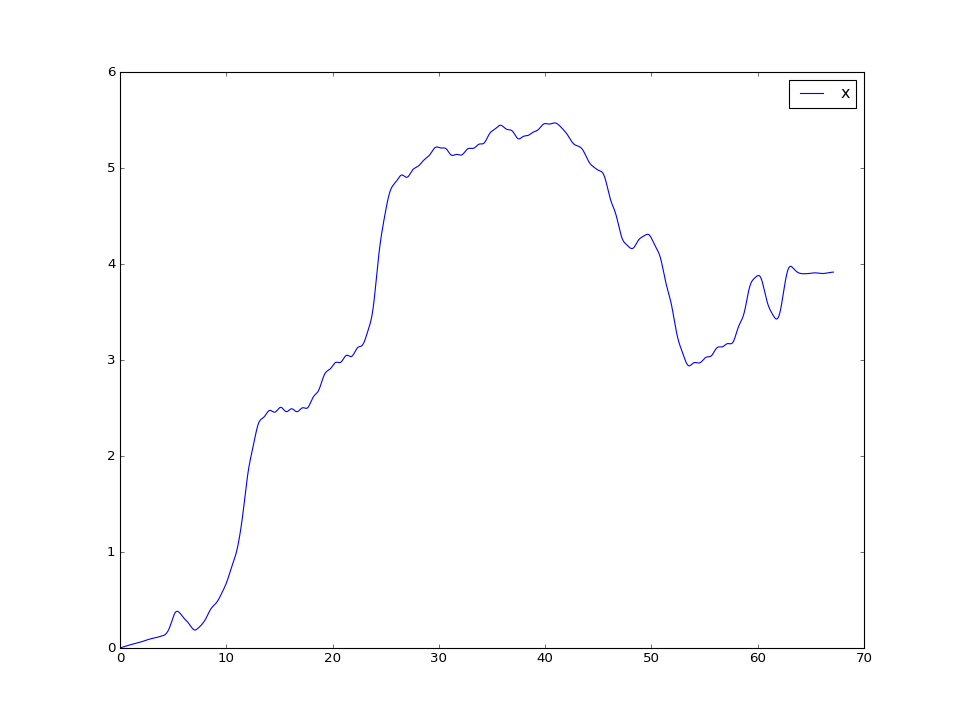

In [128]:
data_all = pandas.read_csv('../../data/iphone_cse1/processed/data.csv')
time_stamp = data_all['time'].values / nano_to_sec
time_stamp -= time_stamp[0]
imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']

target_speed = 
options = td.TrainingDataOption(feature='fourier', window_size=200, frq_threshold=100, sample_step=50)
speed_ind = np.arange(options.window_size_, data_all.shape[0] - 1, options.sample_step_, dtype=int)

filter_sigma = 20.0

linacce = data_all[['linacce_x', 'linacce_y', 'linacce_z']].values
orientation = data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values

filtered_acce = gaussian_filter1d(linacce, sigma=filter_sigma, axis=0)

axis_legend = 'xyz'
plt.figure('Raw acceleration')
plt.title('Raw Acceleration')    
for i in range(3):
    plt.subplot(311+i)
    plt.plot(time_stamp, filtered_acce[:, i])
    plt.legend(axis_legend[i])
    
time_interval = (time_stamp[1:] - time_stamp[:-1])[:, None]
directed_raw_acce = np.empty(linacce.shape, dtype=float)
for i in range(linacce.shape[0]):
    rot = quaternion.as_rotation_matrix(quaternion.quaternion(*orientation[i]))
    directed_raw_acce[i] = np.dot(rot, filtered_acce[i].transpose()).flatten()

directed_raw_acce = gaussian_filter1d(directed_raw_acce, sigma=filter_sigma, axis=0)

raw_speed = np.cumsum((directed_raw_acce[1:] + directed_raw_acce[:-1]) * time_interval / 2.0, axis=0)
plt.figure('Accumulated speed')
plt.plot(time_stamp[1:], np.linalg.norm(raw_speed, axis=1))
plt.legend(['x', 'y', 'z'])